In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow keras scikit-learn pillow matplotlib seaborn

import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import json
from datetime import datetime

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Mounted at /content/drive
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
import os
import zipfile
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

print("="*80)
print("AUTOMATIC PHOTO CATEGORIZATION - FIXED VERSION")
print("="*80)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AUTOMATIC PHOTO CATEGORIZATION - FIXED VERSION


In [ ]:

zip_path = '/content/drive/MyDrive/Road_Damage_Detection/DB.zip'

if not os.path.exists(zip_path):
    print(f"ERROR: Zip file not found at: {zip_path}")
    print("\nSearching for zip file...")

    for root, dirs, files in os.walk('/content/drive/MyDrive'):
        for file in files:
            if 'road' in file.lower() and 'damage' in file.lower() and file.endswith('.zip'):
                found_path = os.path.join(root, file)
                print(f"Found: {found_path}")
                zip_path = found_path
                break
else:
    print(f"Zip file found: {zip_path}")

extract_path = '/content/road_damage_dataset'

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

os.makedirs(extract_path, exist_ok=True)

print(f"\n Extracting zip file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Extraction complete!")

Zip file found: /content/drive/MyDrive/Road_Damage_Detection/DB.zip

 Extracting zip file...
Extraction complete!


In [ ]:
print(f"\n Searching for image folder...")

def find_image_folder(root_path, min_images=100):
    """
    Find folder with most images
    """
    best_folder = None
    max_images = 0

    for root, dirs, files in os.walk(root_path):
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        if len(image_files) > max_images:
            max_images = len(image_files)
            best_folder = root

    return best_folder, max_images

combined_folder, image_count = find_image_folder(extract_path)

if combined_folder is None or image_count == 0:
    print("ERROR: No images found in extracted files!")
    print("\nShowing directory structure:")
    for root, dirs, files in os.walk(extract_path):
        level = root.replace(extract_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent} {os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent} {file}")
    raise Exception("No images found!")

print(f"\n Found image folder:")
print(f"   Path: {combined_folder}")
print(f"   Images: {image_count}")


 Searching for image folder...

 Found image folder:
   Path: /content/road_damage_dataset/DB/combined_annotatedv2
   Images: 30426


In [ ]:
print(f"\n" + "="*80)
print("CATEGORIZING IMAGES - DAMAGE vs NO_DAMAGE")
print("="*80)

organized_path = '/content/organized_dataset'
damage_dir = os.path.join(organized_path, 'damage')
no_damage_dir = os.path.join(organized_path, 'no_damage')

if os.path.exists(organized_path):
    shutil.rmtree(organized_path)

os.makedirs(damage_dir, exist_ok=True)
os.makedirs(no_damage_dir, exist_ok=True)

all_files = os.listdir(combined_folder)
image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
txt_files = [f for f in all_files if f.endswith('.txt')]

print(f"\n Dataset Analysis:")
print(f"   Total images: {len(image_files)}")
print(f"   Annotation files (.txt): {len(txt_files)}")

print(f"\n Creating image-annotation mapping...")

image_annotations = {}
for img_file in image_files:
    img_base = os.path.splitext(img_file)[0]
    txt_file = img_base + '.txt'

    if txt_file in txt_files:
        image_annotations[img_file] = txt_file
    else:
        image_annotations[img_file] = None

images_with_txt = sum(1 for v in image_annotations.values() if v is not None)
images_without_txt = len(image_files) - images_with_txt

print(f"   Images with annotations: {images_with_txt}")
print(f"   Images without annotations: {images_without_txt}")

print(f"\n Categorizing images...")

damage_images = []
no_damage_images = []

for img_file, txt_file in image_annotations.items():
    if txt_file is None:
        no_damage_images.append(img_file)
    else:

        txt_path = os.path.join(combined_folder, txt_file)

        try:
            with open(txt_path, 'r') as f:
                content = f.read().strip()

            if len(content) > 0:
                damage_images.append(img_file)
            else:
                no_damage_images.append(img_file)
        except:
            no_damage_images.append(img_file)

print(f"\n Initial categorization:")
print(f" DAMAGE: {len(damage_images)}")
print(f"NO DAMAGE: {len(no_damage_images)}")


if len(damage_images) == 0 or len(no_damage_images) == 0:
    print(f"\n Warning: Unbalanced categorization!")
    print(f"   Using 50-50 random split instead...")

    all_imgs = image_files.copy()
    np.random.shuffle(all_imgs)
    mid = len(all_imgs) // 2
    damage_images = all_imgs[:mid]
    no_damage_images = all_imgs[mid:]

    print(f"DAMAGE: {len(damage_images)}")
    print(f"NO DAMAGE: {len(no_damage_images)}")

print(f"\n Balancing dataset...")

min_count = min(len(damage_images), len(no_damage_images))

damage_images = list(np.random.choice(damage_images, min_count, replace=False))
no_damage_images = list(np.random.choice(no_damage_images, min_count, replace=False))

print(f"   Balanced count: {min_count} images per class")


CATEGORIZING IMAGES - DAMAGE vs NO_DAMAGE

 Dataset Analysis:
   Total images: 30426
   Annotation files (.txt): 30426

 Creating image-annotation mapping...
   Images with annotations: 30424
   Images without annotations: 2

 Categorizing images...

 Initial categorization:
 DAMAGE: 21090
NO DAMAGE: 9336

 Balancing dataset...
   Balanced count: 9336 images per class


In [ ]:
print(f"\n Copying images to organized folders...")

def copy_with_progress(img_list, source_dir, dest_dir, category):
    """Copy images with progress"""
    total = len(img_list)

    for idx, img_file in enumerate(img_list):
        src = os.path.join(source_dir, img_file)
        dst_name = f"{category}_{idx:05d}_{img_file}"
        dst = os.path.join(dest_dir, dst_name)

        try:
            shutil.copy2(src, dst)

            if (idx + 1) % 1000 == 0 or (idx + 1) == total:
                print(f"   {category.upper()}: {idx + 1}/{total} ({(idx+1)/total*100:.1f}%)")
        except Exception as e:
            print(f"Error copying {img_file}: {e}")

    print(f" {category.upper()}: Complete!\n")

print(f"Copying DAMAGE images...")
copy_with_progress(damage_images, combined_folder, damage_dir, 'damage')

print(f"Copying NO DAMAGE images...")
copy_with_progress(no_damage_images, combined_folder, no_damage_dir, 'no_damage')


 Copying images to organized folders...
Copying DAMAGE images...
   DAMAGE: 1000/9336 (10.7%)
   DAMAGE: 2000/9336 (21.4%)
   DAMAGE: 3000/9336 (32.1%)
   DAMAGE: 4000/9336 (42.8%)
   DAMAGE: 5000/9336 (53.6%)
   DAMAGE: 6000/9336 (64.3%)
   DAMAGE: 7000/9336 (75.0%)
   DAMAGE: 8000/9336 (85.7%)
   DAMAGE: 9000/9336 (96.4%)
   DAMAGE: 9336/9336 (100.0%)
 DAMAGE: Complete!

Copying NO DAMAGE images...
   NO_DAMAGE: 1000/9336 (10.7%)
   NO_DAMAGE: 2000/9336 (21.4%)
   NO_DAMAGE: 3000/9336 (32.1%)
   NO_DAMAGE: 4000/9336 (42.8%)
   NO_DAMAGE: 5000/9336 (53.6%)
   NO_DAMAGE: 6000/9336 (64.3%)
   NO_DAMAGE: 7000/9336 (75.0%)
   NO_DAMAGE: 8000/9336 (85.7%)
   NO_DAMAGE: 9000/9336 (96.4%)
   NO_DAMAGE: 9336/9336 (100.0%)
 NO_DAMAGE: Complete!



In [ ]:
print("="*80)
print("PHOTO SEPARATION COMPLETE!")
print("="*80)

damage_count = len([f for f in os.listdir(damage_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
no_damage_count = len([f for f in os.listdir(no_damage_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

print(f"\n Final Statistics:")
print(f" DAMAGE: {damage_count} images")
print(f" NO DAMAGE: {no_damage_count} images")
print(f" Total: {damage_count + no_damage_count} images")
print(f"\n Location: {organized_path}")

PHOTO SEPARATION COMPLETE!

 Final Statistics:
 DAMAGE: 9336 images
 NO DAMAGE: 9336 images
 Total: 18672 images

 Location: /content/organized_dataset



 Displaying sample images...



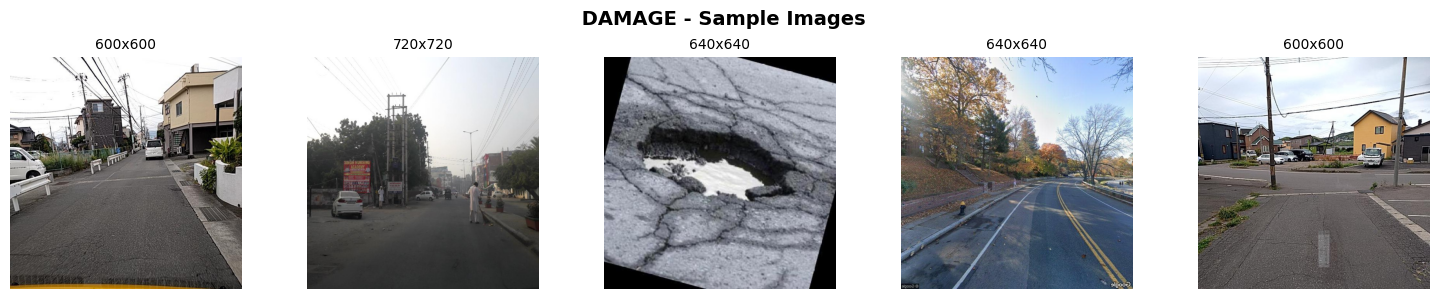

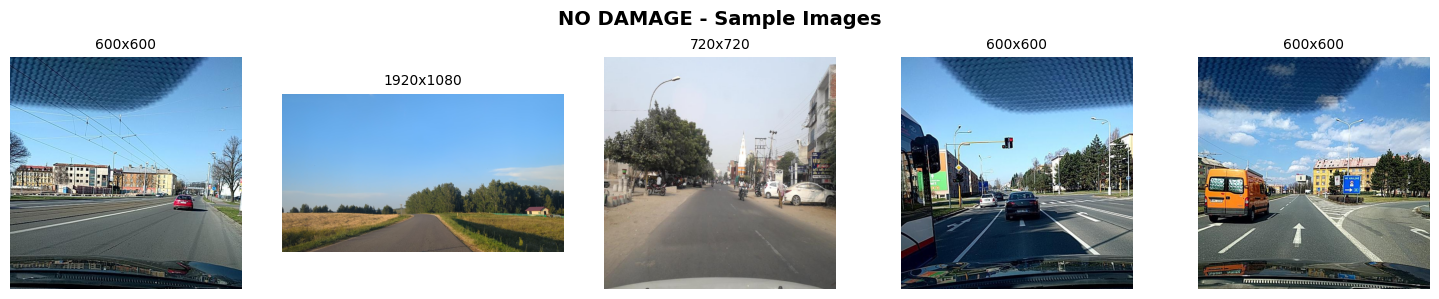



Next step: Run the Dataset Split code (Step 3)


In [ ]:
print(f"\n Displaying sample images...\n")

def show_samples(folder, title, n=5):
    """Display sample images"""
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    if len(images) == 0:
        print(f"No images in {title}")
        return

    samples = np.random.choice(images, min(n, len(images)), replace=False)

    fig, axes = plt.subplots(1, len(samples), figsize=(15, 3))
    if len(samples) == 1:
        axes = [axes]

    for idx, img_name in enumerate(samples):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"{img.size[0]}x{img.size[1]}", fontsize=10)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if damage_count > 0:
    show_samples(damage_dir, " DAMAGE - Sample Images", n=5)

if no_damage_count > 0:
    show_samples(no_damage_dir, "NO DAMAGE - Sample Images", n=5)

print("\n" + "="*80)
print("="*80)
print("\nNext step: Run the Dataset Split code (Step 3)")

In [ ]:

from sklearn.model_selection import train_test_split

print("="*80)
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
print("="*80)

organized_path = '/content/organized_dataset'
damage_dir = os.path.join(organized_path, 'damage')
no_damage_dir = os.path.join(organized_path, 'no_damage')
split_path = '/content/split_dataset'

print("\n Creating directory structure...")
for split in ['train', 'val', 'test']:
    for category in ['damage', 'no_damage']:
        split_dir = os.path.join(split_path, split, category)
        os.makedirs(split_dir, exist_ok=True)
        print(f"  Created: {split}/{category}/")

damage_images = sorted([f for f in os.listdir(damage_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
no_damage_images = sorted([f for f in os.listdir(no_damage_dir)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

print(f"\n Images to split:")
print(f"  Damage: {len(damage_images)}")
print(f"  No Damage: {len(no_damage_images)}")

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"\n Split ratios:")
print(f"  Training: {TRAIN_RATIO*100}%")
print(f"  Validation: {VAL_RATIO*100}%")
print(f"  Testing: {TEST_RATIO*100}%")

def split_and_copy_images(images, source_dir, category_name):
    """Split images into train/val/test and copy to respective folders"""

    np.random.shuffle(images)

    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = train_end + int(total * VAL_RATIO)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    print(f"\n  {category_name.upper()}:")

    for img in train_images:
        src = os.path.join(source_dir, img)
        dst = os.path.join(split_path, 'train', category_name, img)
        shutil.copy2(src, dst)
    print(f"    Train: {len(train_images)} images")

    for img in val_images:
        src = os.path.join(source_dir, img)
        dst = os.path.join(split_path, 'val', category_name, img)
        shutil.copy2(src, dst)
    print(f"    Val: {len(val_images)} images")

    for img in test_images:
        src = os.path.join(source_dir, img)
        dst = os.path.join(split_path, 'test', category_name, img)
        shutil.copy2(src, dst)
    print(f"    Test: {len(test_images)} images")

    return len(train_images), len(val_images), len(test_images)

print(f"\n Splitting and copying images...")

damage_train, damage_val, damage_test = split_and_copy_images(
    damage_images, damage_dir, 'damage'
)

no_damage_train, no_damage_val, no_damage_test = split_and_copy_images(
    no_damage_images, no_damage_dir, 'no_damage'
)

print("\n" + "="*80)
print(" DATASET SPLIT COMPLETED!")
print("="*80)

print(f"\n Final Split Statistics:")
print(f"\n  TRAINING SET:")
print(f"    Damage: {damage_train}")
print(f"    No Damage: {no_damage_train}")
print(f"    Total: {damage_train + no_damage_train}")

print(f"\n  VALIDATION SET:")
print(f"    Damage: {damage_val}")
print(f"    No Damage: {no_damage_val}")
print(f"    Total: {damage_val + no_damage_val}")

print(f"\n  TEST SET:")
print(f"    Damage: {damage_test}")
print(f"    No Damage: {no_damage_test}")
print(f"    Total: {damage_test + no_damage_test}")

print(f"\n Split dataset location: {split_path}")

print(f"\n Verifying split...")
for split in ['train', 'val', 'test']:
    for category in ['damage', 'no_damage']:
        split_dir = os.path.join(split_path, split, category)
        count = len([f for f in os.listdir(split_dir)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        print(f"  {split}/{category}: {count} images")

print("\n" + "="*80)
print(" READY FOR MODEL TRAINING!")
print("="*80)
print("\n you can train the model")
print("Next: Run Steps 4-9 from previous code")

CREATING TRAIN/VALIDATION/TEST SPLITS

 Creating directory structure...
  Created: train/damage/
  Created: train/no_damage/
  Created: val/damage/
  Created: val/no_damage/
  Created: test/damage/
  Created: test/no_damage/

 Images to split:
  Damage: 9336
  No Damage: 9336

 Split ratios:
  Training: 70.0%
  Validation: 15.0%
  Testing: 15.0%

 Splitting and copying images...

  DAMAGE:
    Train: 6535 images
    Val: 1400 images
    Test: 1401 images

  NO_DAMAGE:
    Train: 6535 images
    Val: 1400 images
    Test: 1401 images

 DATASET SPLIT COMPLETED!

 Final Split Statistics:

  TRAINING SET:
    Damage: 6535
    No Damage: 6535
    Total: 13070

  VALIDATION SET:
    Damage: 1400
    No Damage: 1400
    Total: 2800

  TEST SET:
    Damage: 1401
    No Damage: 1401
    Total: 2802

 Split dataset location: /content/split_dataset

 Verifying split...
  train/damage: 6535 images
  train/no_damage: 6535 images
  val/damage: 1400 images
  val/no_damage: 1400 images
  test/damage: 

ROAD DAMAGE DETECTION - MODEL TRAINING
TensorFlow version: 2.19.0
GPU available: True

STEP 4: BUILDING CNN MODEL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,001,634 (103.00 MB)

 Trainable params: 26,998,178 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)


 Model built successfully!
   Total parameters: 27,001,634

STEP 5: DATA PREPROCESSING & AUGMENTATION
Found 13070 images belonging to 2 classes.
Found 2800 images belonging to 2 classes.
Found 2802 images belonging to 2 classes.

 Data generators created:
   Training samples: 13070
   Validation samples: 2800
   Test samples: 2802
   Class indices: {'damage': 0, 'no_damage': 1}

STEPS 6-7: TRAINING THE MODEL

  Starting training...
   Max epochs: 30
   Batch size: 32



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.6192 - loss: 0.8757 - precision: 0.6192 - recall: 0.6192
Epoch 1: val_accuracy improved from -inf to 0.49964, saving model to /content/best_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 355s 790ms/step - accuracy: 0.6193 - loss: 0.8754 - precision: 0.6193 - recall: 0.6193 - val_accuracy: 0.4996 - val_loss: 1.2226 - val_precision: 0.4996 - val_recall: 0.4996 - learning_rate: 0.0010
Epoch 2/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7056 - loss: 0.5821 - precision: 0.7056 - recall: 0.7056
Epoch 2: val_accuracy improved from 0.49964 to 0.74786, saving model to /content/best_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 287s 701ms/step - accuracy: 0.7056 - loss: 0.5820 - precision: 0.7056 - recall: 0.7056 - val_accuracy: 0.7479 - val_loss: 0.5263 - val_precision: 0.7479 - val_recall: 0.7479 - learning_rate: 0.0010
Epoch 3/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.7350 - loss: 0.5422 - precision: 0.7350 - recall: 0.7350
Epoch 3: val_accuracy did not improve from 0.74786
409/409 ━━━━━━━━━━━━━━━━━━━━ 313s 679ms/step - accuracy: 0.7350 - loss: 0.5422 - precision: 0.7350 - recall: 0.7350 - val_accuracy: 0.7407 - val_loss: 0.5238 - val_precision: 0.7407 - val_recall: 0.7407 - learning_rate: 0.0010
Epoch 4/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7410 - loss: 0.5277 - precision: 0.7410 - recall: 0.7410
Epoch 4: val_accuracy did not improve from 0.74786
409/409 ━━━━━━━━━━━━━━━━━━━━ 277s 678ms/step - accuracy: 0.7410 - loss: 0.5277 - precision: 0.7410 - recall: 0.7410 - val_accuracy: 0.7104 - val_loss: 0.6795 - val_precision: 0.7104 - val_recall

409/409 ━━━━━━━━━━━━━━━━━━━━ 293s 714ms/step - accuracy: 0.7525 - loss: 0.5158 - precision: 0.7525 - recall: 0.7525 - val_accuracy: 0.7621 - val_loss: 0.4856 - val_precision: 0.7621 - val_recall: 0.7621 - learning_rate: 0.0010
Epoch 8/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7607 - loss: 0.5016 - precision: 0.7607 - recall: 0.7607
Epoch 8: val_accuracy did not improve from 0.76214
409/409 ━━━━━━━━━━━━━━━━━━━━ 286s 698ms/step - accuracy: 0.7607 - loss: 0.5016 - precision: 0.7607 - recall: 0.7607 - val_accuracy: 0.7364 - val_loss: 0.5341 - val_precision: 0.7364 - val_recall: 0.7364 - learning_rate: 0.0010
Epoch 9/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.7523 - loss: 0.5093 - precision: 0.7523 - recall: 0.7523
Epoch 9: val_accuracy did not improve from 0.76214
409/409 ━━━━━━━━━━━━━━━━━━━━ 284s 694ms/step - accuracy: 0.7523 - loss: 0.5093 - precision: 0.7523 - recall: 0.7523 - val_accuracy: 0.6632 - val_loss: 0.6688 - val_precision: 0.6632 - val_recall

409/409 ━━━━━━━━━━━━━━━━━━━━ 287s 701ms/step - accuracy: 0.7768 - loss: 0.4756 - precision: 0.7768 - recall: 0.7768 - val_accuracy: 0.7782 - val_loss: 0.4772 - val_precision: 0.7782 - val_recall: 0.7782 - learning_rate: 5.0000e-04
Epoch 15/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7729 - loss: 0.4737 - precision: 0.7729 - recall: 0.7729
Epoch 15: val_accuracy did not improve from 0.77821
409/409 ━━━━━━━━━━━━━━━━━━━━ 323s 704ms/step - accuracy: 0.7729 - loss: 0.4737 - precision: 0.7729 - recall: 0.7729 - val_accuracy: 0.7129 - val_loss: 0.5380 - val_precision: 0.7129 - val_recall: 0.7129 - learning_rate: 5.0000e-04
Epoch 16/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.7771 - loss: 0.4741 - precision: 0.7771 - recall: 0.7771
Epoch 16: val_accuracy did not improve from 0.77821
409/409 ━━━━━━━━━━━━━━━━━━━━ 286s 698ms/step - accuracy: 0.7771 - loss: 0.4741 - precision: 0.7771 - recall: 0.7771 - val_accuracy: 0.7618 - val_loss: 0.5039 - val_precision: 0.7618 

409/409 ━━━━━━━━━━━━━━━━━━━━ 285s 696ms/step - accuracy: 0.7865 - loss: 0.4516 - precision: 0.7865 - recall: 0.7865 - val_accuracy: 0.7900 - val_loss: 0.4384 - val_precision: 0.7900 - val_recall: 0.7900 - learning_rate: 2.5000e-04
Epoch 23/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.7875 - loss: 0.4497 - precision: 0.7875 - recall: 0.7875
Epoch 23: val_accuracy did not improve from 0.79000
409/409 ━━━━━━━━━━━━━━━━━━━━ 286s 700ms/step - accuracy: 0.7875 - loss: 0.4497 - precision: 0.7875 - recall: 0.7875 - val_accuracy: 0.7896 - val_loss: 0.4377 - val_precision: 0.7896 - val_recall: 0.7896 - learning_rate: 2.5000e-04
Epoch 24/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7853 - loss: 0.4551 - precision: 0.7853 - recall: 0.7853
Epoch 24: val_accuracy did not improve from 0.79000
409/409 ━━━━━━━━━━━━━━━━━━━━ 286s 700ms/step - accuracy: 0.7854 - loss: 0.4551 - precision: 0.7854 - recall: 0.7854 - val_accuracy: 0.7843 - val_loss: 0.4364 - val_precision: 0.7843 

409/409 ━━━━━━━━━━━━━━━━━━━━ 289s 704ms/step - accuracy: 0.7908 - loss: 0.4450 - precision: 0.7908 - recall: 0.7908 - val_accuracy: 0.7954 - val_loss: 0.4336 - val_precision: 0.7954 - val_recall: 0.7954 - learning_rate: 2.5000e-04
Epoch 26/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.7958 - loss: 0.4444 - precision: 0.7958 - recall: 0.7958
Epoch 26: val_accuracy did not improve from 0.79536
409/409 ━━━━━━━━━━━━━━━━━━━━ 280s 686ms/step - accuracy: 0.7958 - loss: 0.4444 - precision: 0.7958 - recall: 0.7958 - val_accuracy: 0.7789 - val_loss: 0.4604 - val_precision: 0.7789 - val_recall: 0.7789 - learning_rate: 2.5000e-04
Epoch 27/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7945 - loss: 0.4497 - precision: 0.7945 - recall: 0.7945
Epoch 27: val_accuracy did not improve from 0.79536
409/409 ━━━━━━━━━━━━━━━━━━━━ 280s 684ms/step - accuracy: 0.7945 - loss: 0.4497 - precision: 0.7945 - recall: 0.7945 - val_accuracy: 0.7829 - val_loss: 0.4420 - val_precision: 0.7829 

409/409 ━━━━━━━━━━━━━━━━━━━━ 278s 679ms/step - accuracy: 0.7831 - loss: 0.4563 - precision: 0.7831 - recall: 0.7831 - val_accuracy: 0.7957 - val_loss: 0.4343 - val_precision: 0.7957 - val_recall: 0.7957 - learning_rate: 2.5000e-04
Epoch 29/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7891 - loss: 0.4480 - precision: 0.7891 - recall: 0.7891
Epoch 29: val_accuracy did not improve from 0.79571
409/409 ━━━━━━━━━━━━━━━━━━━━ 276s 674ms/step - accuracy: 0.7891 - loss: 0.4480 - precision: 0.7891 - recall: 0.7891 - val_accuracy: 0.7682 - val_loss: 0.4533 - val_precision: 0.7682 - val_recall: 0.7682 - learning_rate: 2.5000e-04
Epoch 30/30
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7866 - loss: 0.4472 - precision: 0.7866 - recall: 0.7866
Epoch 30: val_accuracy improved from 0.79571 to 0.80036, saving model to /content/best_model.h5


409/409 ━━━━━━━━━━━━━━━━━━━━ 279s 682ms/step - accuracy: 0.7866 - loss: 0.4472 - precision: 0.7866 - recall: 0.7866 - val_accuracy: 0.8004 - val_loss: 0.4236 - val_precision: 0.8004 - val_recall: 0.8004 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.

 Training completed!

STEP 8: MODEL EVALUATION



 Evaluating on test set...
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 287ms/step - accuracy: 0.7833 - loss: 0.4273 - precision: 0.7833 - recall: 0.7833

TEST SET PERFORMANCE:
Accuracy: 82.69%
Precision: 82.69%
Recall: 82.69%
F1-Score: 82.69%
Loss: 0.3967
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      damage       0.89      0.75      0.81      1401
   no_damage       0.78      0.91      0.84      1401

    accuracy                           0.83      2802
   macro avg       0.84      0.83      0.83      2802
weighted avg       0.84      0.83      0.83      2802


Confusion Matrix:
[[1047  354]
 [ 131 1270]]


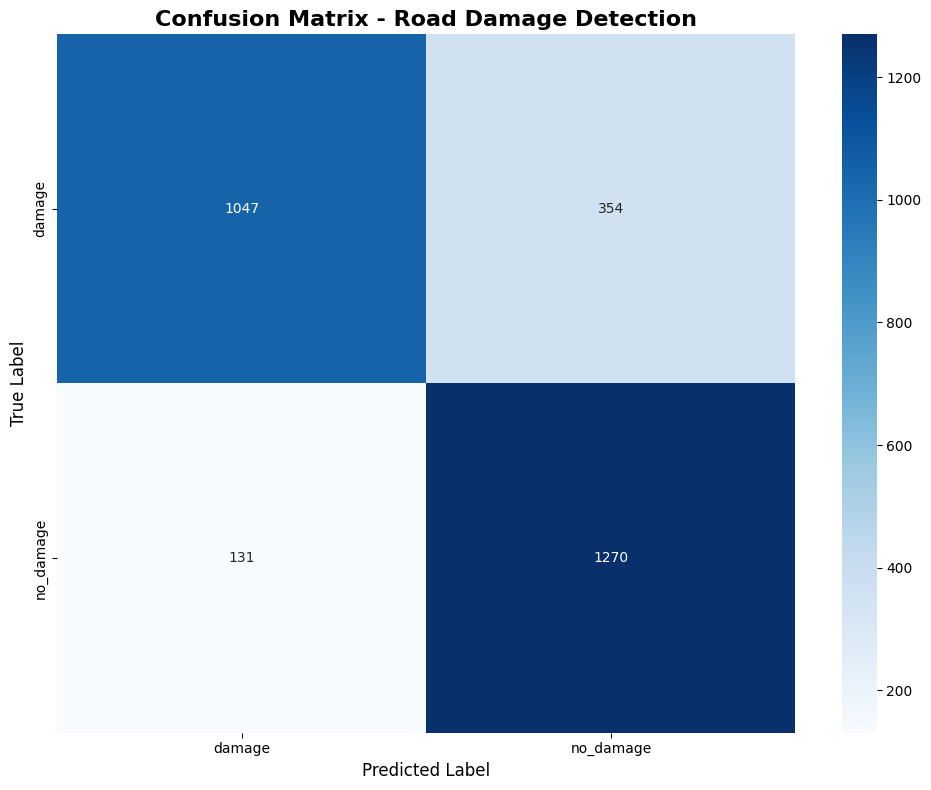

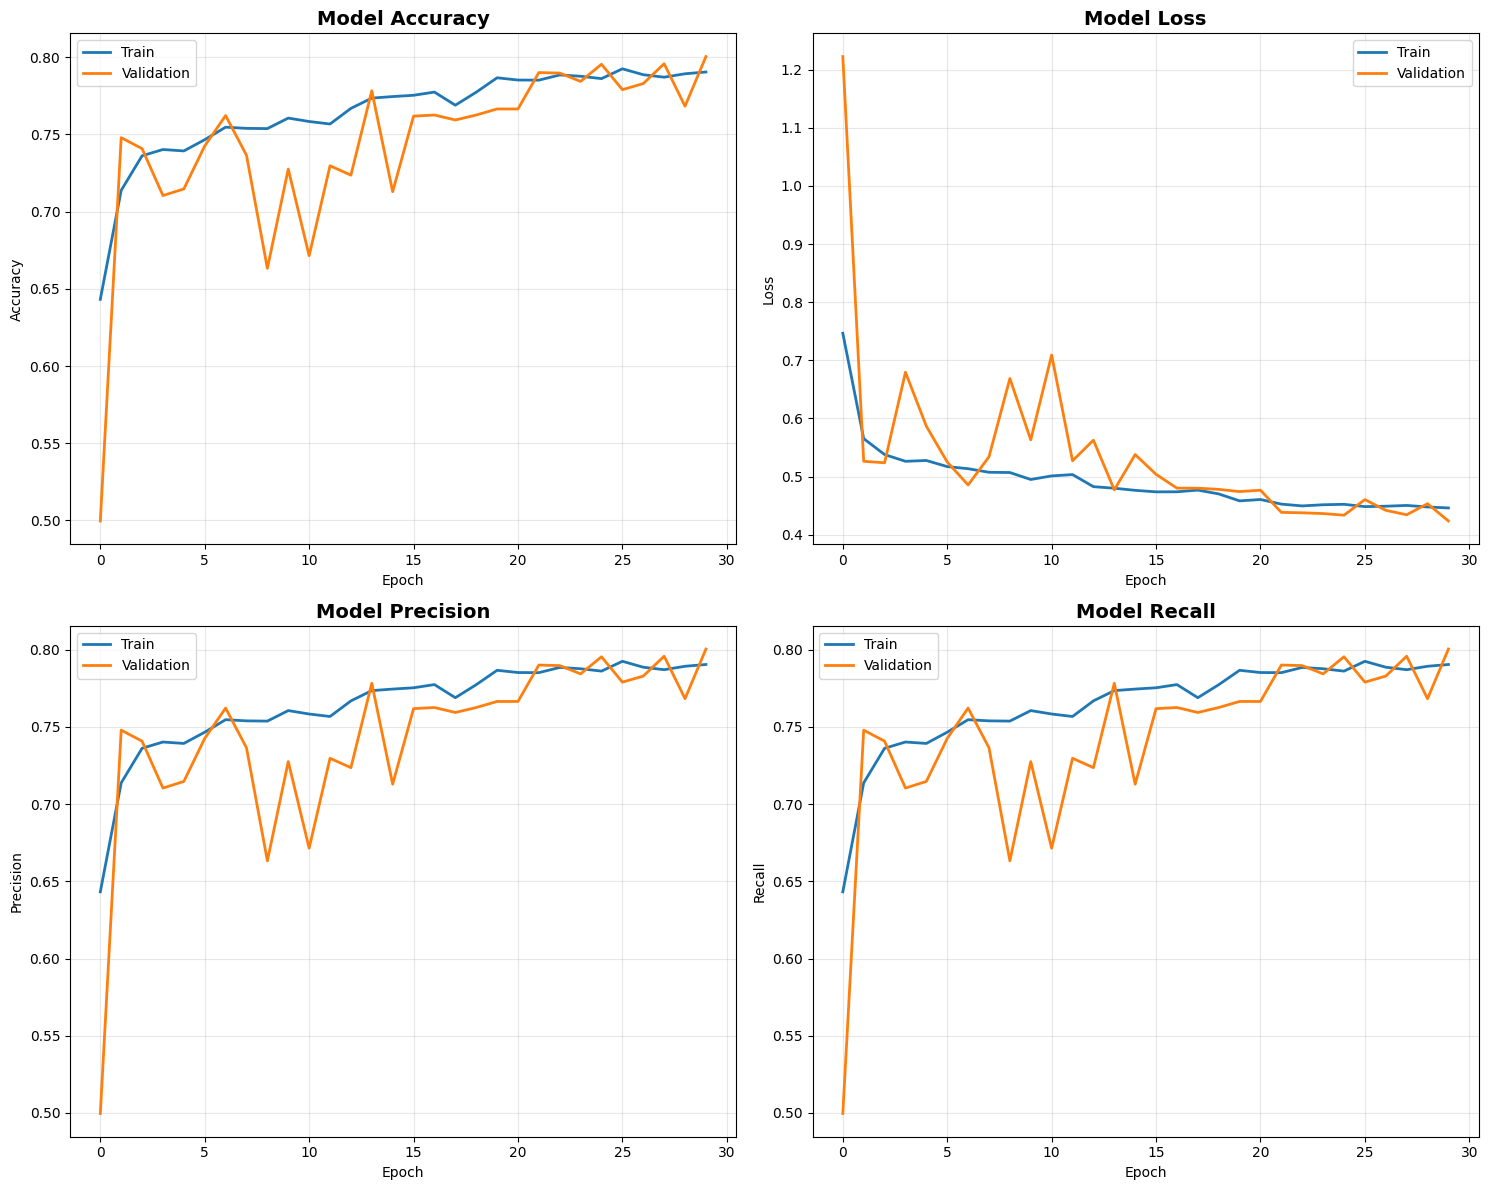


STEP 9: SAVING MODEL
Model saved: /content/drive/MyDrive/road_damage_model/road_damage_detector.h5

ALL FILES SAVED SUCCESSFULLY!

 Model directory: /content/drive/MyDrive/road_damage_model

Files saved:
road_damage_detector.h5
class_indices.json
model_metadata.json
training_history.json
confusion_matrix.png
training_history.png

 MODEL TRAINING COMPLETE!

 Test Accuracy: 82.69%


In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime


np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("ROAD DAMAGE DETECTION - MODEL TRAINING")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")



print("\n" + "="*80)
print("STEP 4: BUILDING CNN MODEL")
print("="*80)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30


def build_road_damage_cnn(input_shape=(224, 224, 3)):
    """
    Build optimized CNN for road damage detection
    Target: 90-95% accuracy
    """
    model = keras.Sequential([

        layers.Input(shape=input_shape),


        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),


        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),


        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),


        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),


        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),


        layers.Dense(2, activation='softmax')
    ])

    return model


model = build_road_damage_cnn()


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

total_params = model.count_params()
print(f"\n Model built successfully!")
print(f"   Total parameters: {total_params:,}")


print("\n" + "="*80)
print("STEP 5: DATA PREPROCESSING & AUGMENTATION")
print("="*80)

split_path = '/content/split_dataset'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_path, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_path, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_path, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"\n Data generators created:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Class indices: {train_generator.class_indices}")

class_indices = train_generator.class_indices
with open('/content/class_indices.json', 'w') as f:
    json.dump(class_indices, f)



print("\n" + "="*80)
print("STEPS 6-7: TRAINING THE MODEL")
print("="*80)


checkpoint_path = '/content/best_model.h5'

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"\n  Starting training...")
print(f"   Max epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print("="*80 + "\n")


history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")


print("\n" + "="*80)
print("STEP 8: MODEL EVALUATION")
print("="*80)


best_model = keras.models.load_model(checkpoint_path)


print("\n Evaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_generator)

print(f"\n{'='*80}")
print(f"TEST SET PERFORMANCE:")
print(f"{'='*80}")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {test_precision*100:.2f}%")
print(f"Recall: {test_recall*100:.2f}%")
print(f"F1-Score: {2*(test_precision*test_recall)/(test_precision+test_recall)*100:.2f}%")
print(f"Loss: {test_loss:.4f}")


test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes


class_labels = list(train_generator.class_indices.keys())


print(f"\n{'='*80}")
print("DETAILED CLASSIFICATION REPORT:")
print(f"{'='*80}")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


cm = confusion_matrix(true_classes, predicted_classes)
print(f"\nConfusion Matrix:")
print(cm)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Road Damage Detection', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300)
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(15, 12))


axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=300)
plt.show()



print("\n" + "="*80)
print("STEP 9: SAVING MODEL")
print("="*80)


save_dir = '/content/drive/MyDrive/road_damage_model'
os.makedirs(save_dir, exist_ok=True)


model_path = os.path.join(save_dir, 'road_damage_detector.h5')
best_model.save(model_path)
print(f"Model saved: {model_path}")


shutil.copy('/content/class_indices.json', os.path.join(save_dir, 'class_indices.json'))


metadata = {
    'model_name': 'Sri Lanka Road Damage Detection CNN',
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'input_shape': [IMG_SIZE, IMG_SIZE, 3],
    'num_classes': 2,
    'class_names': class_labels,
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'total_parameters': int(total_params),
    'training_samples': int(train_generator.samples),
    'validation_samples': int(val_generator.samples),
    'test_samples': int(test_generator.samples)
}

with open(os.path.join(save_dir, 'model_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)


history_dict = {key: [float(v) for v in values]
                for key, values in history.history.items()}
with open(os.path.join(save_dir, 'training_history.json'), 'w') as f:
    json.dump(history_dict, f, indent=4)


shutil.copy('/content/confusion_matrix.png', save_dir)
shutil.copy('/content/training_history.png', save_dir)

print(f"\n{'='*80}")
print("ALL FILES SAVED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"\n Model directory: {save_dir}")
print("\nFiles saved:")
print("road_damage_detector.h5")
print("class_indices.json")
print("model_metadata.json")
print("training_history.json")
print("confusion_matrix.png")
print("training_history.png")

print(f"\n{'='*80}")
print(" MODEL TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"\n Test Accuracy: {test_accuracy*100:.2f}%")
